from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
Packages

In [1]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve

import catboost
from catboost import CatBoostClassifier

Data

In [2]:
gender_submission = pd.read_csv('titanic_data/gender_submission.csv')

In [3]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [4]:
gender_submission.shape

(418, 2)

In [5]:
x_train_old = pd.read_csv('titanic_data/train.csv')

In [6]:
x_train_old.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
x_train_old.shape

(891, 12)

In [8]:
x_train_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
x_test_old = pd.read_csv('titanic_data/test.csv')

In [10]:
x_test_old.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [11]:
x_test_old.shape

(418, 11)

Simple feature engineering

In [12]:
x_train = x_train_old.copy()
x_test = x_test_old.copy()

In [13]:
x_train.drop('PassengerId', inplace = True, axis = 1)

In [14]:
x_test.drop('PassengerId', inplace = True, axis = 1)

In [15]:
categorical_feats = x_train.select_dtypes(include = 'object').columns.tolist()

In [16]:
categorical_feats

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [17]:
continuous_feats = x_train.select_dtypes(exclude = 'object').columns.tolist()

In [18]:
continuous_feats

['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [19]:
x_train[categorical_feats] = x_train[categorical_feats].replace({np.nan: "None"})

In [20]:
x_train[continuous_feats] = x_train[continuous_feats].replace({np.nan:0})

In [21]:
x_test[categorical_feats] = x_test[categorical_feats].replace({np.nan: "None"})

In [22]:
x_test[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']] = x_test[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].replace({np.nan:0})

Catboost modeling

In [23]:
classes = np.unique(x_train.Survived)

In [24]:
classes

array([0, 1])

In [25]:
weights = compute_class_weight(class_weight = 'balanced', classes = classes, y = x_train.Survived)

In [26]:
weights

array([0.81147541, 1.30263158])

In [27]:
class_weights_dict = dict(zip(classes, weights))

In [28]:
class_weights_dict

{0: 0.8114754098360656, 1: 1.3026315789473684}

In [29]:
catboost_model = CatBoostClassifier(class_weights = [class_weights_dict[0], class_weights_dict[1]], \
                                    verbose = 0, thread_count = 5)

In [30]:
catboost_model.fit(x_train.drop('Survived', axis = 1), x_train.Survived, categorical_feats)

In [31]:
cb_pred = catboost_model.predict_proba(x_test)[:, 1]

Evaluation and threshold determination

In [32]:
def tune_threshold_for_recall(y_true, y_score, cv=None, target_precision=0.8):
    """
    Given ground truth labels y_true and raw "probability" scores,
    finds the decision threshold t such that cutting y_score >= t
    gives a precision equal or higher to target_precision.
    
    TODO handle cases where the target_precision is not achievable
    and jumps directly to 1.
    """
    if cv is not None:
        if isinstance(cv, int):
            cv = KFold(n_splits=cv)
        else:
            # assumes cv is already a sklearn CV object
            assert isinstance(cv, BaseCrossValidator)
        
        # convert Series to numpy arrays to avoid indexing issues
        if isinstance(y_true, pd.Series):
            y_true = y_true.values
        if isinstance(y_score, pd.Series):
            y_score = y_score.values
        
        splits = cv.split(y_true)

        thresholds, precisions, recalls = list(), list(), list()
        for train_idx, _ in splits:
            thresh, precision, recall = tune_threshold_for_recall(y_true[train_idx],
                                                                  y_score[train_idx],
                                                                  cv=None,
                                                                  target_precision=target_precision,
                                                                 )
            thresholds.append(thresh)
            precisions.append(precision)
            recalls.append(recall)
        return round(np.mean(thresholds), 2), round(np.mean(precisions), 2), round(np.mean(recalls), 2)
            
    p, r, t = precision_recall_curve(y_true, y_score)

    best_recall = np.max(r[p >= target_precision])
    best_idx = np.where(r == best_recall)[0]
    best_precision = p[best_idx]

    # there might be a tie where multiple thresholds achieve same recall
    # in which case, pick best precision
    if len(best_idx) > 1:
        best_precision_idx = np.argmax(best_precision) # in case of ties, argmax returns first occurence
        best_precision = best_precision[best_precision_idx]
        best_idx = best_idx[best_precision_idx]
    
    best_threshold = t[best_idx]
    return round(best_threshold, 2), round(best_precision, 2), round(best_recall, 2)

In [33]:
best_th, best_p, best_r = tune_threshold_for_recall(gender_submission.Survived, cb_pred)

In [34]:
print("=== Catboost Model ===")
print("Best Threshold: " + str(best_th))
print("Best Precision: " + str(best_p))
print("Best Recall: " + str(best_r))

=== Catboost Model ===
Best Threshold: 0.5
Best Precision: 0.81
Best Recall: 0.93


Feature importance of initial Catboost model

In [35]:
cb_fi = pd.DataFrame()

cb_fi['feature'] = catboost_model.feature_names_
cb_fi['importance'] =  catboost_model.feature_importances_
cb_fi.sort_values(by = 'importance', ascending = False, inplace = True)
cb_fi.head(10)

,feature,importance
2,Sex,30.340461
3,Age,14.015916
6,Ticket,12.099843
0,Pclass,9.152286
7,Fare,9.121130
8,Cabin,9.042703
9,Embarked,7.508187
5,Parch,5.070231
4,SibSp,3.649242
1,Name,0.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

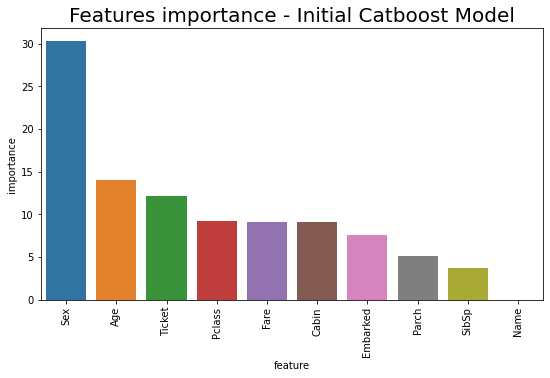

In [36]:
plt.figure(figsize = (9,5))
fi_initial = sns.barplot(x='feature',y='importance',data=cb_fi)
fi_initial.set_xticklabels(fi_initial.get_xticklabels(),rotation=90)
fi_initial.set_title('Features importance - Initial Catboost Model',fontsize=20)
plt.show()

## False Positive Analysis

Merge the df with the `Survived` label onto the testing df, `df_test`

In [37]:
x_test_old.head()
#x_test_old.shape

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [38]:
x_test.head()
#x_test.shape

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,None,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,None,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,None,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,None,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,None,S


In [39]:
gender_submission.head()
#gender_submission.shape

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [40]:
x_test_old_merged = pd.merge(x_test_old, gender_submission, on = 'PassengerId')

In [41]:
x_test_old_merged.head()
#x_test_old_merged.shape

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


Add the prediction probability from the Catboost model, `cb_pred`, as a column to the merged df from above

In [42]:
x_test_old_merged['survived_pred_prob'] = cb_pred.tolist()

In [43]:
x_test_old_merged.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,survived_pred_prob
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0.160811
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,0.394768
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0.190899
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0.160978
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,0.936209


Use the best threshold, `best_th`, created above to created a field that indicates whether or not the model predicted survival

In [44]:
predicted_survival = x_test_old_merged['survived_pred_prob'] > best_th

In [45]:
predicted_survival.value_counts()

False    243
True     175
Name: survived_pred_prob, dtype: int64

Of the 175 passengers that were predicted to have survived, which of them were incorrectly predicted (false positives).

Create a column that indicates the passenger was a false positive survival

In [46]:
x_test_old_merged['FP'] = predicted_survival & (x_test_old_merged['Survived'] == 0)

In [47]:
x_test_old_merged.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,survived_pred_prob,FP
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0.160811,False
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,0.394768,False
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0.190899,False
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0.160978,False
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,0.936209,False


Filter for only the false positive survived passengers and check the shape to count how many there are

In [48]:
false_positives = x_test_old_merged[x_test_old_merged['FP'] == True]

display(false_positives.head())

print("Shape: " + str(false_positives.shape))
print("False Positive Count: " + str(false_positives.shape[0]))

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,survived_pred_prob,FP
28,920,1,"Brady, Mr. John Bertram",male,41.0,0,0,113054,30.5000,A21,S,0,0.518735,True
34,926,1,"Mock, Mr. Philipp Edmund",male,30.0,1,0,13236,57.7500,C78,C,0,0.521872,True
39,931,3,"Hee, Mr. Ling",male,NaN,0,0,1601,56.4958,NaN,S,0,0.629467,True
41,933,1,"Franklin, Mr. Thomas Parham",male,NaN,0,0,113778,26.5500,D34,S,0,0.597787,True
50,942,1,"Smith, Mr. Lucien Philip",male,24.0,1,0,13695,60.0000,C31,S,0,0.554872,True


Shape: (33, 14)
False Positive Count: 33


Convert `FP` column from boolean to integer

In [49]:
x_test_old_merged['FP'].dtype

dtype('bool')

In [50]:
x_test_old_merged['FP'] = x_test_old_merged['FP'].astype('int64')

In [51]:
x_test_old_merged['FP'].dtype

dtype('int64')

In [52]:
x_test_old_merged.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,survived_pred_prob,FP
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0.160811,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,0.394768,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0.190899,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0.160978,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,0.936209,0


Run another Catboost model on the data from the cell above, treating the false postives as the label to predict.

Ultimately, we will do some feature importance to find the features that lead to false positivest the most.

In [53]:
# dorp the Survived and survived_pred_prob columns
df = x_test_old_merged.copy()
df = df.drop(['Survived', 'survived_pred_prob'], axis = 1)

In [54]:
# also drop PassengerId column
df = df.drop('PassengerId', axis = 1)

In [55]:
# split into train/test values
x = df.drop(["FP"], axis=1) # setting the X to do the split
y = df["FP"] # transforming the values in array

In [56]:
# split the data into train/test set (using train/test values from above)
x_train_fp, x_test_fp, y_train_fp, y_test_fp = train_test_split(x, y, random_state=2, test_size=0.20)

<IPython.core.display.Javascript object>

In [57]:
categorical_feats_fp = list(x_train_fp.select_dtypes(include = 'object').columns)
categorical_feats_fp

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [58]:
continuous_feats_fp = list(x_train_fp.select_dtypes(exclude = 'object').columns)
continuous_feats_fp

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [59]:
x_train_fp[categorical_feats_fp] = x_train_fp[categorical_feats_fp].replace({np.nan: "None"})

/Users/audreyholloman/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [60]:
x_train_fp[continuous_feats_fp] = x_train_fp[continuous_feats_fp].replace({np.nan:0})

In [61]:
x_test_fp[categorical_feats_fp] = x_test_fp[categorical_feats_fp].replace({np.nan: "None"})

In [62]:
x_test_fp[continuous_feats_fp] = x_test_fp[continuous_feats_fp].replace({np.nan:0})

Catboost modeling (on false positives)

In [63]:
classes_fp = np.unique(y_train_fp)

In [64]:
classes_fp

array([0, 1])

In [65]:
weights_fp = compute_class_weight(class_weight = 'balanced', classes = classes_fp, y = y_train_fp)

In [66]:
weights_fp

array([0.54575163, 5.96428571])

In [67]:
class_weights_dict_fp = dict(zip(classes_fp, weights_fp))

In [68]:
class_weights_dict_fp

{0: 0.545751633986928, 1: 5.964285714285714}

In [69]:
catboost_model_fp = CatBoostClassifier(class_weights = [class_weights_dict_fp[0], class_weights_dict_fp[1]], \
                                    verbose = 0, thread_count = 5)

In [70]:
catboost_model_fp.fit(x_train_fp, y_train_fp, categorical_feats)

In [71]:
cb_pred_fp = catboost_model_fp.predict_proba(x_test_fp)[:, 1]

Feature importance of false positive Catboost model

In [72]:
cb_fi_fp = pd.DataFrame()

cb_fi_fp['feature'] = catboost_model_fp.feature_names_
cb_fi_fp['importance'] =  catboost_model_fp.feature_importances_
cb_fi_fp.sort_values(by = 'importance', ascending = False, inplace = True)
cb_fi_fp.head(10)

,feature,importance
2,Sex,32.026979
8,Cabin,17.519425
3,Age,17.382001
7,Fare,15.275851
5,Parch,7.258903
9,Embarked,4.259307
0,Pclass,3.733890
6,Ticket,1.673152
4,SibSp,0.870493
1,Name,0.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

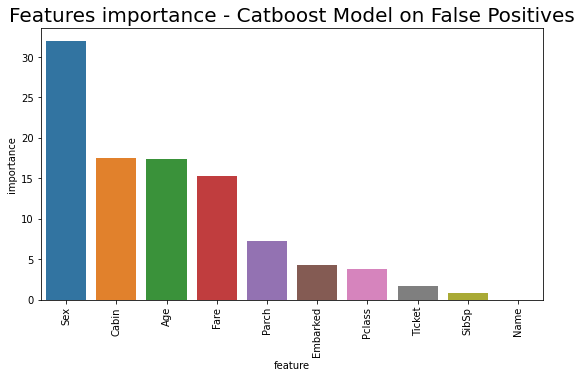

In [73]:
plt.figure(figsize = (9,5))
fi_fp = sns.barplot(x='feature',y='importance',data=cb_fi_fp)
fi_fp.set_xticklabels(fi_fp.get_xticklabels(),rotation=90)
fi_fp.set_title('Features importance - Catboost Model on False Positives',fontsize=20)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

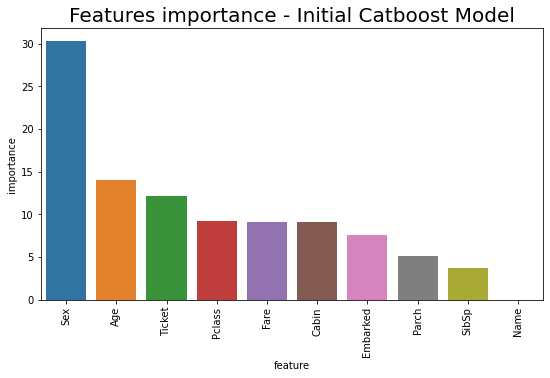

In [74]:
# compare with feature importance of initial Catboost model
plt.figure(figsize = (9,5))
fi_initial = sns.barplot(x='feature',y='importance',data=cb_fi)
fi_initial.set_xticklabels(fi_initial.get_xticklabels(),rotation=90)
fi_initial.set_title('Features importance - Initial Catboost Model',fontsize=20)
plt.show()

## Remove important features and re-run Catboost model on same initial data (with `Survival` as the label and not `FP`)

All of the same features that are important when predicting false positive survival (`false positive Catboost model`) are also important in predicting survival (`initial Catboost model`)

Let's take out the `Sex` feauture since it's the most important feature that was returned from the `false positive Catboost model` (even though it's also the most important feature in the `initial Catboost model`)

The goal is to see if there are less false positives returned from the model. We're looking for a false positive count < 33

In [75]:
x_train_2 = x_train.copy()
x_test_2 = x_test.copy()

In [76]:
x_train_2.drop('Sex', inplace = True, axis = 1)
x_test_2.drop('Sex', inplace = True, axis = 1)

In [77]:
categorical_feats_2 = x_train_2.select_dtypes(include = 'object').columns.tolist()
categorical_feats_2

['Name', 'Ticket', 'Cabin', 'Embarked']

In [78]:
continuous_feats_2 = x_train_2.select_dtypes(exclude = 'object').columns.tolist()
continuous_feats_2

['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [79]:
x_train_2[categorical_feats_2] = x_train_2[categorical_feats_2].replace({np.nan: "None"})
x_train_2[continuous_feats_2] = x_train_2[continuous_feats_2].replace({np.nan:0})

x_test_2[categorical_feats_2] = x_test_2[categorical_feats_2].replace({np.nan: "None"})
x_test_2[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']] = x_test_2[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].replace({np.nan:0})

Catboost model with the `Sex` feature removed

In [80]:
classes_2 = np.unique(x_train_2.Survived)

In [81]:
classes_2

array([0, 1])

In [82]:
weights_2 = compute_class_weight(class_weight = 'balanced', classes = classes_2, y = x_train_2.Survived)

In [83]:
weights_2

array([0.81147541, 1.30263158])

In [84]:
class_weights_dict_2 = dict(zip(classes_2, weights_2))

In [85]:
class_weights_dict_2

{0: 0.8114754098360656, 1: 1.3026315789473684}

In [86]:
catboost_model_2 = CatBoostClassifier(class_weights = [class_weights_dict_2[0], class_weights_dict_2[1]], \
                                    verbose = 0, thread_count = 5)

In [87]:
catboost_model_2.fit(x_train_2.drop('Survived', axis = 1), x_train_2.Survived, categorical_feats_2)

In [88]:
cb_pred_2 = catboost_model_2.predict_proba(x_test_2)[:, 1]

Evaluation and threshold determination

In [89]:
best_th_2, best_p_2, best_r_2 = tune_threshold_for_recall(gender_submission.Survived, cb_pred_2)

In [90]:
print("=== Catboost Model ===")
print("Best Threshold: " + str(best_th_2))
print("Best Precision: " + str(best_p_2))
print("Best Recall: " + str(best_r_2))

=== Catboost Model ===
Best Threshold: 0.93
Best Precision: 1.0
Best Recall: 0.03


Get the false positive count with the model run without the `Sex` feature

In [97]:
x_test_old_merged_2 = pd.merge(x_test_old, gender_submission, on = 'PassengerId')
x_test_old_merged_2.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [99]:
x_test_old_merged_2['survived_pred_prob_2'] = cb_pred_2.tolist()
x_test_old_merged_2.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,survived_pred_prob_2
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0.351449
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,0.058075
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0.421301
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0.244481
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,0.772655


In [100]:
predicted_survival_t1 = x_test_old_merged_2['survived_pred_prob_2'] > best_th
predicted_survival_t2 = x_test_old_merged_2['survived_pred_prob_2'] > best_th_2

In [104]:
x_test_old_merged_2['FP_t1'] = predicted_survival_t1 & (x_test_old_merged_2['Survived'] == 0)
x_test_old_merged_2['FP_t2'] = predicted_survival_t2 & (x_test_old_merged_2['Survived'] == 0)

In [108]:
x_test_old_merged_2.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,survived_pred_prob_2,FP_t1,FP_t2
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0.351449,False,False
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,0.058075,False,False
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0.421301,False,False
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0.244481,False,False
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,0.772655,False,False


In [118]:
print("Using Initial Threshold of " + str(best_th) + ":")
print("False Positive Count: " + str(x_test_old_merged_2[x_test_old_merged_2['FP_t1'] == True].shape[0]))

Using Initial Threshold of 0.5:
False Positive Count: 93


In [119]:
print("Using New Threshold of " + str(best_th_2) + ":")
print("False Positive Count: " + str(x_test_old_merged_2[x_test_old_merged_2['FP_t2'] == True].shape[0]))

Using New Threshold of 0.93:
False Positive Count: 0
